In [1]:
# Load modules
import sys
sys.path.append('../utilities_tlezuo/')

import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
from wrf import getvar, interp1d
from netCDF4 import Dataset

from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import datetime as dt

from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
###############################################################################################
## CONSTANT FILE  ##
c_filename = "lfff00000000c.nc"
filepath = '/store/s83/swester/teamx/tdf_2019091212/output/19091212/'
const_file = filepath + c_filename
data_c = psy.open_dataset(const_file)

###############################################################################################
## DECIDE ##
# where to save
loadpath = '/users/tlezuo/icon-vis/height_time_diagrams/data/'
# decide which locations to calculate
loc_list = []
# loc_list.extend([])
loc_list=[lf.kols]

# decide which variables to calculate
pvars_list = []
# pvars_list.extend([vf.qv_2m,vf.T_2M])
pvars_list= [vf.U, vf.V, vf.T,vf.TH,vf.QV,vf.P,vf.VEL,vf.DIR]

###############################################################################################
## DATELISTS ##
# ICON model: as writeout times: 30 min
startdate_model = dt.datetime(2019,9,12,12,00)
enddate_model = dt.datetime(2019,9,14,00,00)
plotdates_model = pd.date_range(startdate_model,enddate_model,freq='0h30min')
plotdates_model_list = list(plotdates_model)
# radiosoundings: 3h and 2h intervals
plotdates_rs = [dt.datetime(2019,9,12,23,00),dt.datetime(2019,9,13,3,00),dt.datetime(2019,9,13,6,00),dt.datetime(2019,9,13,9,00),
dt.datetime(2019,9,13,11,00),dt.datetime(2019,9,13,13,00),dt.datetime(2019,9,13,15,00),dt.datetime(2019,9,13,17,00),dt.datetime(2019,9,13,20,00),dt.datetime(2019,9,13,23,00)]
# radiosoundings Munich: 00+12
plotdates_murs = [dt.datetime(2019,9,12,12,00),dt.datetime(2019,9,13,0,00),dt.datetime(2019,9,13,12,00),dt.datetime(2019,9,14,0,00)]
# lidar SL88: 10 min
plotdates_lidar_SL88 = pd.date_range(dt.datetime(2019,9,13,0,00),enddate_model,freq='0h10min')
plotdates_lidar_SL88_list = list(plotdates_lidar_SL88)

In [3]:
## LOAD DATA ##
# ICON model
htd_data_model = {}
htd_data_model['kols'] = np.load(loadpath+'htd_ICON_kols.npy',allow_pickle='TRUE').item()
htd_data_model['murs'] = np.load(loadpath+'htd_ICON_murs.npy',allow_pickle='TRUE').item()
htd_data_model['ifl'] = np.load(loadpath+'htd_ICON_ifl.npy',allow_pickle='TRUE').item()

# Streamline Lidar SL88
htd_data_lidar_SL88 = xr.open_dataset(loadpath+'htd_lidar_SL88_Kolsass.nc').load()
htd_data_lidar_SL88_interp = np.load(loadpath+'htd_lidar_SL88_interp_Kolsass.npy',allow_pickle='TRUE').item()
# Streamline Lidar SLXR142
htd_data_lidar_SLXR142 = xr.open_dataset(loadpath+'htd_lidar_SLXR142_Kolsass.nc').load()
# htd_data_lidar_SLXR142_interp = np.load(loadpath+'htd_lidar_SLXR142_interp_Kolsass.npy',allow_pickle='TRUE').item()
# HATPRO Lidar
htd_data_lidar_hatpro = xr.open_dataset(loadpath+'htd_lidar_hatpro_Kolsass.nc').load()
htd_data_lidar_hatpro = htd_data_lidar_hatpro.transpose()

# Kolsass radiosoundings
htd_data_kolsrs = np.load(loadpath+'htd_rs_Kolsass.npy',allow_pickle='TRUE').item()
htd_data_kolsrs_interp = np.load(loadpath+'htd_rs_interp_Kolsass.npy',allow_pickle='TRUE').item()
# Munich radiosounding
htd_data_murs = np.load(loadpath+'htd_rs_Munich.npy',allow_pickle='TRUE').item()
htd_data_murs_interp = np.load(loadpath+'htd_rs_interp_Munich.npy',allow_pickle='TRUE').item()
# Innsbruck radiosounding
htd_data_iflrs = np.load(loadpath+'htd_rs_Innsbruck.npy',allow_pickle='TRUE').item()
htd_data_iflrs_interp = np.load(loadpath+'htd_rs_interp_Innsbruck.npy',allow_pickle='TRUE').item()

In [34]:
def get_sounding(pvar,pdate,loc):
    # model levels
    lev_model = htd_data_model[loc.short]['HFL_loc']
    lev_model_cut = lev_model[0:73]

    # indices for model
    ti_model = plotdates_model_list.index(pdate)

    # get data model
    sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])
    sounding_model_cut = sounding_model[0:73]       

    if pdate.strftime('%H') == '02': # if 02 -> we want to see ifl sounding
        # index for rs Innsbruck is always 0
        ti_rs = 0
        sounding_rs_interp = np.array(htd_data_iflrs_interp[pvar.name][ti_rs,:])
    
    elif pdate.strftime('%H') == '12' or pdate.strftime('%H') ==  '00': # if 12 or 00 -> we want to see murs sounding
        # index for rs Munich
        ti_rs = plotdates_murs.index(pdate)
        sounding_rs_interp = np.array(htd_data_murs_interp[pvar.name][ti_rs,:])
    
    else: # else -> we want Kolsass/CROSSINN sounding
        # index for rs Kolsass
        ti_rs = plotdates_rs.index(pdate)
        sounding_rs_interp = np.array(htd_data_kolsrs_interp[pvar.name][ti_rs,:])

    return lev_model_cut,sounding_model_cut,sounding_rs_interp,ti_model,ti_rs

def plot_sounding(pvar, pdate, loc, axis, addlid=False):

    lev_model_cut,sounding_model_cut,sounding_rs_interp,ti_model,ti_rs = get_sounding(pvar,pdate,loc)                                                                                          
    # plot it
    m = axis.plot(sounding_model_cut,  lev_model_cut, lw=2,color='dodgerblue',label='ICON')
    r = axis.plot(sounding_rs_interp,  lev_model_cut, lw=2,color='darkviolet',label='radiosoundings')
    
    
    # add lidar
    if addlid == True:
        # time index
        ti_lidar_SL88 = plotdates_lidar_SL88_list.index(pdate)
        # ti_lidar_SLXR142
        # get data
        if pvar.name == 'VEL':
            # 1) SL 88
            sounding_lidar_SL88_cut = htd_data_lidar_SL88_interp[pvar.name][ti_lidar_SL88] # get data
            slc_mask = np.isfinite(sounding_lidar_SL88_cut) # mask nan
            sounding_lidar_cut_SL88_ind = np.where(~np.isnan(sounding_lidar_SL88_cut)) # get ind of nonmasked
            lev_lidar_SL88_values = np.array(htd_data_model['kols']['HFL_loc'][sounding_lidar_cut_SL88_ind]) # select levels to which data belongs
            # plot
            axis.plot(sounding_lidar_SL88_cut[slc_mask], lev_lidar_SL88_values,color='crimson',label='lidar SL88')
            # extra plot original non-vert-interpolated data
            # axis.plot(htd_data_lidar_SL88['VEL'][ti_lidar], htd_data_lidar_SL88['height'],color='red',label='lidar SL88 (original)') # real, non interpolated to model levels

            q_scale = 30
            q_width = 0.002
            U_lidar_SL88 = htd_data_lidar_SL88_interp['U'][ti_lidar_SL88][slc_mask]
            V_lidar_SL88 = htd_data_lidar_SL88_interp['V'][ti_lidar_SL88][slc_mask]
            axis.quiver(np.full(len(lev_lidar_SL88_values),16.6), lev_lidar_SL88_values, U_lidar_SL88, V_lidar_SL88, 
                scale=q_scale, scale_units='inches', width=q_width,color='crimson')


    # fill between to highlight bias
    axis.fill_betweenx(lev_model_cut, sounding_model_cut, sounding_rs_interp, where=(sounding_model_cut > sounding_rs_interp), alpha=0.2, color='orangered')
    axis.fill_betweenx(lev_model_cut, sounding_model_cut, sounding_rs_interp, where=(sounding_model_cut < sounding_rs_interp), alpha=0.2, color='cyan')

    # title
    axis.set_title(pdate.strftime('%H:%M'), fontsize=12)
    
    # windbarbs
    if pvar.name == 'VEL':
        q_scale = 30
        q_width = 0.002
        lev_model_cut,U_model,U_rs,ti_model,ti_rs = get_sounding(vf.U,pdate,loc)
        lev_model_cut,V_model,V_rs,ti_model,ti_rs = get_sounding(vf.V,pdate,loc)
        axis.quiver(np.full(73,20), lev_model_cut, U_model, V_model, 
            scale=q_scale, scale_units='inches', width=q_width,color='dodgerblue')
        axis.quiver(np.full(73,15), lev_model_cut, U_rs,V_rs, 
            scale=q_scale, scale_units='inches', width=q_width,color='darkviolet')


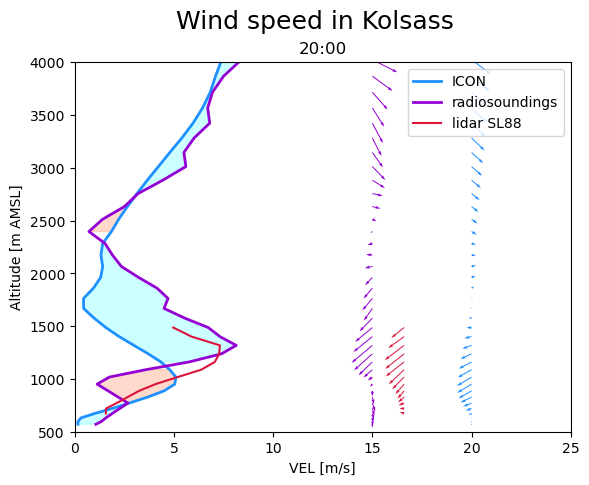

In [40]:
## PLOT SINGLE PROFILE ##
# general settings
pvar = vf.VEL
loc= lf.kols
pdate = dt.datetime(2019,9,13,20,00) # only at rs times

# plotsettings
# xmin=0
xmax=25
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
plot_sounding(pvar, pdate, loc, ax, addlid=True)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)

# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

In [6]:
sounding_lidar_cut_ind = np.where(~np.isnan(sounding_lidar_cut))
htd_data_lidar_SL88['VEL'][ti_lidar],htd_data_lidar_SL88['height']


(<xarray.DataArray 'VEL' (height: 83)>
 array([      nan,       nan,       nan, 2.353871 , 2.5213523, 2.8381302,
        3.1735132, 3.3961334, 3.495406 , 3.277125 , 2.9541304, 2.6943994,
        2.4991086, 2.3491666, 2.2315114, 2.1582963, 2.1570466, 2.2085936,
        2.1697843, 1.7101824, 1.7027441, 1.6009308, 2.1197855, 1.6607939,
        1.8985453, 2.3020544,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,
              nan,       nan,       nan,       nan,       nan,       nan,

In [7]:
import numpy.ma as ma
sounding_lidar_cut_m = ma.array(sounding_lidar_cut, mask= slc_mask)
ma.MaskedArray.nonzero(sounding_lidar_cut_m)
sounding_lidar_cut_m.nonzero

<bound method MaskedArray.nonzero of masked_array(data=[nan, nan, nan, --, --, --, --, --, --, --, --, --, --,
                   --, --, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                   nan, nan, nan, nan, nan, nan],
             mask=[False, False, False,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False],
       fill_value=1e+20)>

In [8]:
sounding_lidar_cut

array([       nan,        nan,        nan, 2.39116979, 2.71539783,
       3.20465207, 3.47472048, 3.09668732, 2.60962152, 2.30058861,
       2.15768266, 2.18277407, 1.70323944, 1.98508239, 2.19879723,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

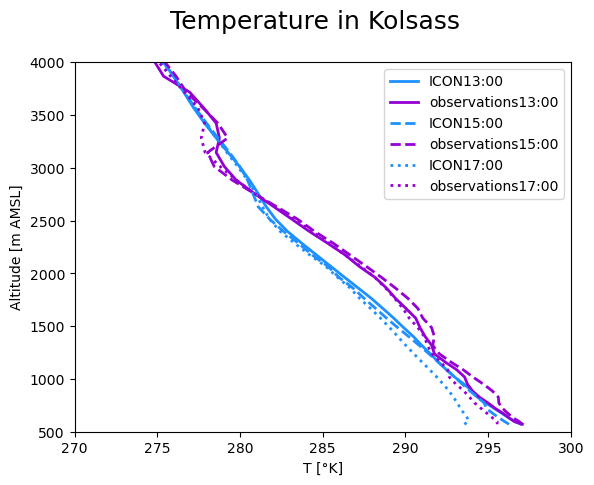

In [9]:
## PLOT MULTIPLE PROFILES of Kolsass in 1 PLOT ##
# general settings
pvar = vf.T
pdate1 = dt.datetime(2019,9,13,13,00)
loc1= lf.kols
pdate2 = dt.datetime(2019,9,13,15,00)
loc2= lf.kols
pdate3 = dt.datetime(2019,9,13,17,00)
loc3= lf.kols

# plotsettings
xmin=270
xmax=300
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# first time
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1) 
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label='ICON'+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label='observations'+pdate1.strftime('%H:%M'))
# second time
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc2) 
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label='ICON'+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label='observations'+pdate2.strftime('%H:%M'))
# # third time
lev_model_cut,sounding_model_cut3,sounding_rs_interp3,ti_model3,ti_rs3 = get_sounding(pvar,pdate3,loc3) 
m3 = ax.plot(sounding_model_cut3,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dotted',label='ICON'+pdate3.strftime('%H:%M'))
r3 = ax.plot(sounding_rs_interp3,  lev_model_cut, lw=2,color='darkviolet',linestyle='dotted',label='observations'+pdate3.strftime('%H:%M'))
                                                                                                                                                                          
# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

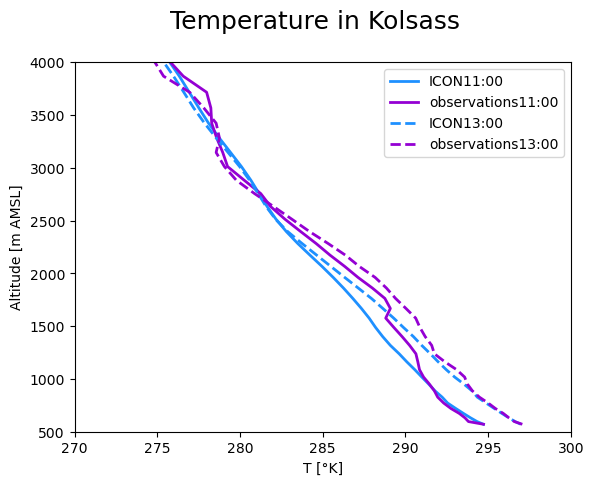

In [10]:
## PLOT MULTIPLE PROFILES of Kolsass in 1 PLOT ##
# general settings
pvar = vf.T
pdate1 = dt.datetime(2019,9,13,11,00)
loc1= lf.kols
pdate2 = dt.datetime(2019,9,13,13,00)
loc2= lf.kols
# pdate3 = dt.datetime(2019,9,13,17,00)
# loc3= lf.kols

# plotsettings
xmin=270
xmax=300
ymin=500
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.99)
# first time
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1) 
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label='ICON'+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label='observations'+pdate1.strftime('%H:%M'))
# second time
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc2) 
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label='ICON'+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label='observations'+pdate2.strftime('%H:%M'))
# # third time
# lev_model_cut,sounding_model_cut3,sounding_rs_interp3,ti_model3,ti_rs3 = get_sounding(pvar,pdate3,loc3) 
# m3 = ax.plot(sounding_model_cut3,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dotted',label='ICON'+pdate3.strftime('%H:%M'))
# r3 = ax.plot(sounding_rs_interp3,  lev_model_cut, lw=2,color='darkviolet',linestyle='dotted',label='observations'+pdate3.strftime('%H:%M'))
                                                                                                                                                                          
# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin,ymax+1,500))
plt.legend()

plt.show()

/tmp/ipykernel_111413/1504316187.py:10: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])
/tmp/ipykernel_111413/1504316187.py:10: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])


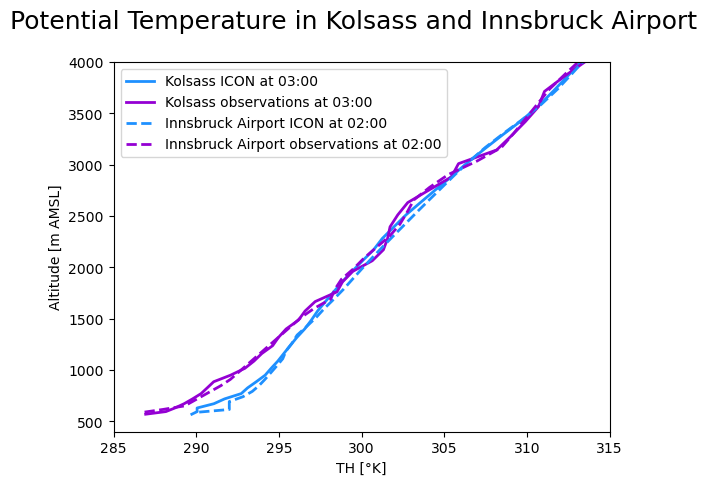

In [11]:
## COMPARE VALLEY AND PLAIN 1: 12 vs 13##
# general settings
pvar = vf.TH

pdate1 = dt.datetime(2019,9,13,3,00)
loc1= lf.kols
pdate2 = dt.datetime(2019,9,13,2,00)
loc2= lf.ifl

# plotsettings
xmin=285
xmax=315
ymin=400
ymax=4000
xdelticks=5

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in '+loc1.name + ' and ' +loc2.name  , fontsize=18, y=0.99)
# first time
lev_model_cut,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1) 
m1 = ax.plot(sounding_model_cut1,  lev_model_cut, lw=2,color='dodgerblue',linestyle='solid',label=loc1.name+' ICON at '+pdate1.strftime('%H:%M'))
r1 = ax.plot(sounding_rs_interp1,  lev_model_cut, lw=2,color='darkviolet',linestyle='solid',label=loc1.name+' observations at '+pdate1.strftime('%H:%M'))
# second time
lev_model_cut,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc2) 
m2 = ax.plot(sounding_model_cut2,  lev_model_cut, lw=2,color='dodgerblue',linestyle='dashed',label=loc2.name+' ICON at '+pdate2.strftime('%H:%M'))
r2 = ax.plot(sounding_rs_interp2,  lev_model_cut, lw=2,color='darkviolet',linestyle='dashed',label=loc2.name+' observations at '+pdate2.strftime('%H:%M'))
                                                                                                                                                                          
# x

ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin+100,ymax+1,500))
plt.legend()

plt.show()

/tmp/ipykernel_111413/1504316187.py:10: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc.short][pvar.name][ti_model,:])
/tmp/ipykernel_111413/2287149277.py:22: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  sounding_model = np.array(htd_data_model[loc1.short][pvar.name][ti_model3,:])


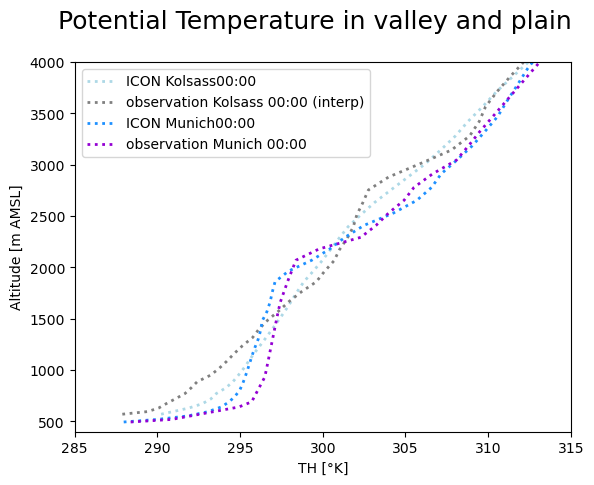

In [12]:
## COMPARE VALLEY AND PLAIN 2: 12 vs 12interp ##
pvar = vf.TH

# interpolate Kolsass rs to 12 UTC to compare with Munich
pdate1 = dt.datetime(2019,9,12,23,00)
pdate2 = dt.datetime(2019,9,13,3,00)
pdate3 = dt.datetime(2019,9,13,0,00)
delt_rs = pdate2 - pdate1
delt_interp = pdate3 - pdate1
loc1= lf.kols

# get rs and model data at 11 and 13 UTC in Kolsass
lev_model_cut_kols,sounding_model_cut1,sounding_rs_interp1,ti_model1,ti_rs1 = get_sounding(pvar,pdate1,loc1)
lev_model_cut_kols,sounding_model_cut2,sounding_rs_interp2,ti_model2,ti_rs2 = get_sounding(pvar,pdate2,loc1)  
# interpolate
sounding_rs_interp3kols_i= sounding_rs_interp1+(sounding_rs_interp2-sounding_rs_interp1)/(delt_rs.seconds/3600)*(delt_interp.seconds/3600)

# get rs and model data at 12 in Munich
loc2= lf.murs
lev_model_cut_murs,sounding_model_cut3murs,sounding_rs_interp3murs,ti_model3,ti_rs3 = get_sounding(pvar,pdate3,loc2) 
# get model data in Kolsass at 12 UTC
sounding_model = np.array(htd_data_model[loc1.short][pvar.name][ti_model3,:])
sounding_model_cut3kols = sounding_model[0:73]

## PLOT ##
# plotsettings 
xmin=285
xmax=315
ymin=400
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' in valley and plain', fontsize=18, y=0.99)
# # first time Kolsass
# m1 = ax.plot(sounding_model_cut1,  lev_model_cut_kols, lw=2,color='dodgerblue',linestyle='solid',label='ICON'+pdate1.strftime('%H:%M'))
# r1 = ax.plot(sounding_rs_interp1,  lev_model_cut_kols, lw=2,color='darkviolet',linestyle='solid',label='Kolsass '+pdate1.strftime('%H:%M'))
# second time Kolsass
# m2 = ax.plot(sounding_model_cut2,  lev_model_cut_kols, lw=2,color='dodgerblue',linestyle='dashed',label='ICON'+pdate2.strftime('%H:%M'))
# r2 = ax.plot(sounding_rs_interp2,  lev_model_cut_kols, lw=2,color='darkviolet',linestyle='dashed',label='Kolsass '+pdate2.strftime('%H:%M'))
# interp time Kolsass
m3 = ax.plot(sounding_model_cut3kols,  lev_model_cut_kols, lw=2,color='lightblue',linestyle='dotted',label='ICON Kolsass'+pdate3.strftime('%H:%M'))
r3 = ax.plot(sounding_rs_interp3kols_i,  lev_model_cut_kols, lw=2,color='grey',linestyle='dotted',label='observation Kolsass '+pdate3.strftime('%H:%M')+' (interp)')
# interp time Munich
m3 = ax.plot(sounding_model_cut3murs,  lev_model_cut_murs, lw=2,color='dodgerblue',linestyle='dotted',label='ICON Munich'+pdate3.strftime('%H:%M'))
r3 = ax.plot(sounding_rs_interp3murs,  lev_model_cut_murs, lw=2,color='darkviolet',linestyle='dotted',label='observation Munich '+pdate3.strftime('%H:%M'))

# x
xdelticks=5
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin+100,ymax+101,500))
plt.legend()

plt.show()

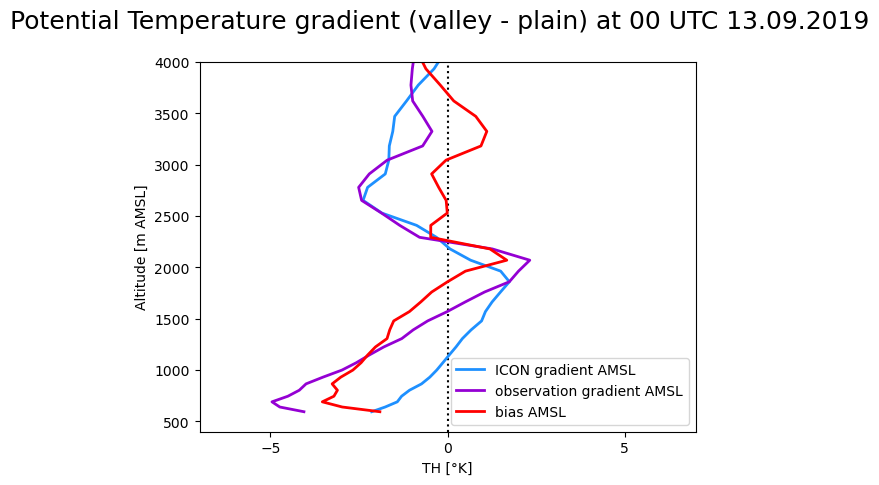

In [13]:
## COMPARE VALLEY AND PLAIN 3: gradients ##
# delX = Xvalley - Xplain

# approach 1: between altitudes AMSL
# for this we need to interpolate kols data (rs+model) to murs levels
sounding_rs_interp3kols_i_lm  = interp1d(sounding_rs_interp3kols_i, lev_model_cut_kols, np.transpose(lev_model_cut_murs)) # lm= levels murs
sounding_model_cut3kols_lm  = interp1d(sounding_model_cut3kols, lev_model_cut_kols, np.transpose(lev_model_cut_murs)) # lm= levels murs
# we exclude firs three datapoints, as they are unphysical (interpolation of rs to sub-topo altitudes)
lev_model_cut_murs_cut = lev_model_cut_murs[3:73]
# compute gradients
del_model_amsl = sounding_model_cut3kols_lm[3:73] - sounding_model_cut3murs[3:73]
del_rs_amsl = sounding_rs_interp3kols_i_lm[3:73] - sounding_rs_interp3murs[3:73]


# approach 2: between altitudes AGL: treat values as they where on same levels
# compute gradients
del_model_agl = sounding_model_cut3kols - sounding_model_cut3murs
del_rs_agl = sounding_rs_interp3kols_i - sounding_rs_interp3murs

# decide which to use: look at model bias
bias_amsl = del_rs_amsl - del_model_amsl
bias_agl = del_rs_agl - del_model_agl

## PLOT ##
# plotsettings 
xmin=-7
xmax=7
xdelticks=5
ymin=400
ymax=4000

f, ax = plt.subplots(1,1)
f.suptitle(pvar.title+' gradient (valley - plain) at '+pdate3.strftime('%H UTC %d.%m.%Y'), fontsize=18, y=0.99)
ax.vlines(0,ymin,ymax,colors='k', linestyles='dotted')
# approach 1 AMSL
m3 = ax.plot(del_model_amsl,  lev_model_cut_murs_cut, lw=2,color='dodgerblue',linestyle='solid',label='ICON gradient AMSL')
r3 = ax.plot(del_rs_amsl,  lev_model_cut_murs_cut, lw=2,color='darkviolet',linestyle='solid',label='observation gradient AMSL')
bias = ax.plot(bias_amsl,  lev_model_cut_murs_cut, lw=2,color='red',linestyle='solid',label='bias AMSL')
# approach 1 AGL
# m3 = ax.plot(del_model_agl,  lev_model_cut_murs, lw=2,color='dodgerblue',linestyle='dotted',label='ICON gradient AGL')
# r3 = ax.plot(del_rs_agl,  lev_model_cut_murs, lw=2,color='darkviolet',linestyle='dotted',label='observation gradient AGL')
# bias = ax.plot(bias_agl,  lev_model_cut_murs, lw=2,color='red',linestyle='dotted',label='bias AGL')


# x
ax.set_xlim([xmin,xmax])
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_xticks(np.arange(xmin+2,xmax+1,xdelticks))
# y
ax.set_ylim([ymin,ymax])
ax.set_ylabel('Altitude [m AMSL]')
ax.set_yticks(np.arange(ymin+100,ymax+101,500))
plt.legend()

plt.show()


In [14]:
## COMPARE VALLEY AND PLAIN 3: model gradients for whole model time series ##
# approach 1: between altitudes AMSL -> as delP only works here
for pvar in pvars_list:
    # make space in dataset
    htd_data_model['kols'][pvar.name+'_grad']= np.zeros((len(plotdates_model),70)) 
for counter,pdate in enumerate(plotdates_model):
    for pvar in pvars_list:
        # interpolate kols model data to murs levels
        kols_data_lm = interp1d(htd_data_model['kols'][pvar.name][counter], htd_data_model['kols']['HFL_loc'], np.transpose(htd_data_model['murs']['HFL_loc'])) # lm= levels murs
        # get murs data to subtract
        murs_data_lm = np.array(htd_data_model['murs'][pvar.name][counter])
        htd_data_model['kols'][pvar.name+'_grad'][counter] =  kols_data_lm[3:73] - murs_data_lm[3:73] # exclude lowest 3 datapoints


/scratch/tlezuo/miniconda3/envs/psyplot/lib/python3.9/site-packages/wrf/extension.py:156: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result = dinterp1d(v_in,
/tmp/ipykernel_111413/3971117692.py:11: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  murs_data_lm = np.array(htd_data_model['murs'][pvar.name][counter])


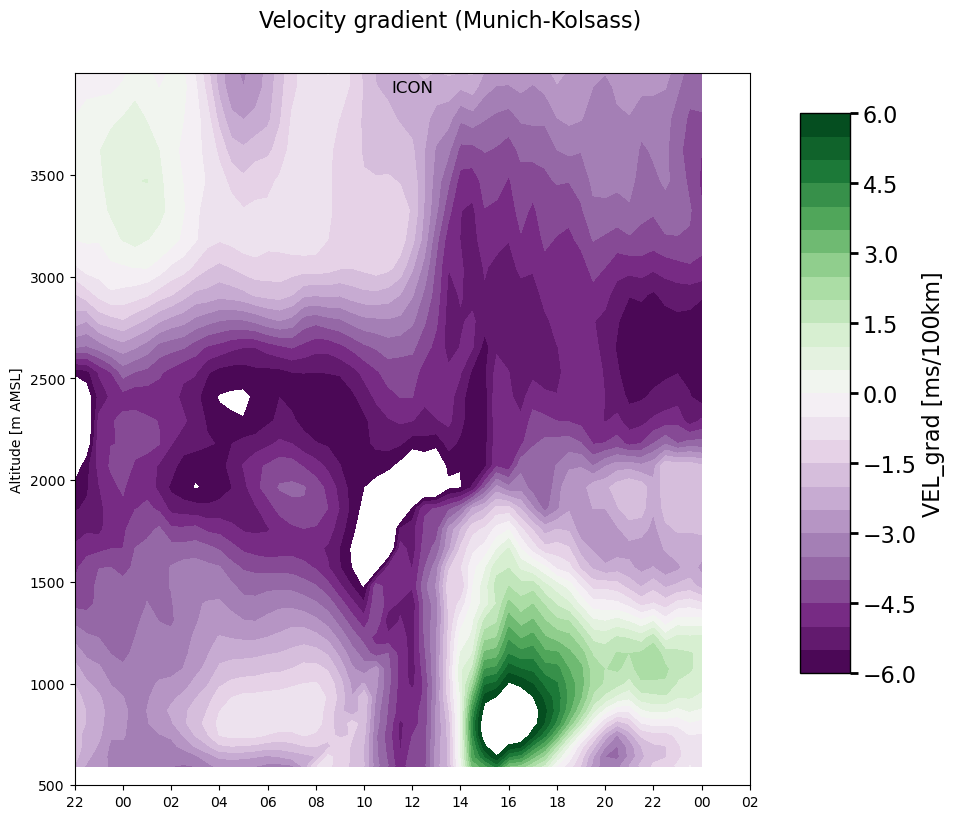

In [15]:
## PLOT ##
# variable
pvar = vf.VEL_grad
levels = np.arange(pvar.min,pvar.max+0.1,pvar.ticks)

# vertical range
zmin = 500
zmax = 4000
altitudes = np.arange(zmin,zmax,500)

# time range
startdate_plot = dt.datetime(2019,9,12,22,00)
enddate_plot = dt.datetime(2019,9,14,2,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

# figure settings
fig, ax1 = plt.subplots(1,1, figsize=(10,8))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.1)
fig.suptitle(pvar.title, fontsize=16)

# plot
x1 = plotdates_model
y1 = htd_data_model['murs']['HFL_loc'][3:73]
z1 = np.transpose(htd_data_model['kols'][pvar.name])
cf = ax1.contourf(x1,y1,z1, levels = levels, cmap=pvar.cmap)

# plotting options
ax1.set_ylim(zmin,zmax)
ax1.set_xlim(startdate_plot,enddate_plot)
# ax1.grid()
ax1.set_title('ICON', y=1.0, pad=-14)
# ax1.set_xlabel('Time [h]')
ax1.set_xticks(plotdates_plot)
ax1.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
ax1.set_ylabel('Altitude [m AMSL]')
ax1.set_yticks(altitudes)

# add colorbar 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cf, cax=cbar_ax)
# cbar = plt.colorbar(cf,orientation='vertical')
cbar.ax.tick_params(labelsize=16,width=2,length=6)
cbar.set_label(pvar.name+' '+pvar.units,fontsize=16)
cbar.outline.set_linewidth(1)

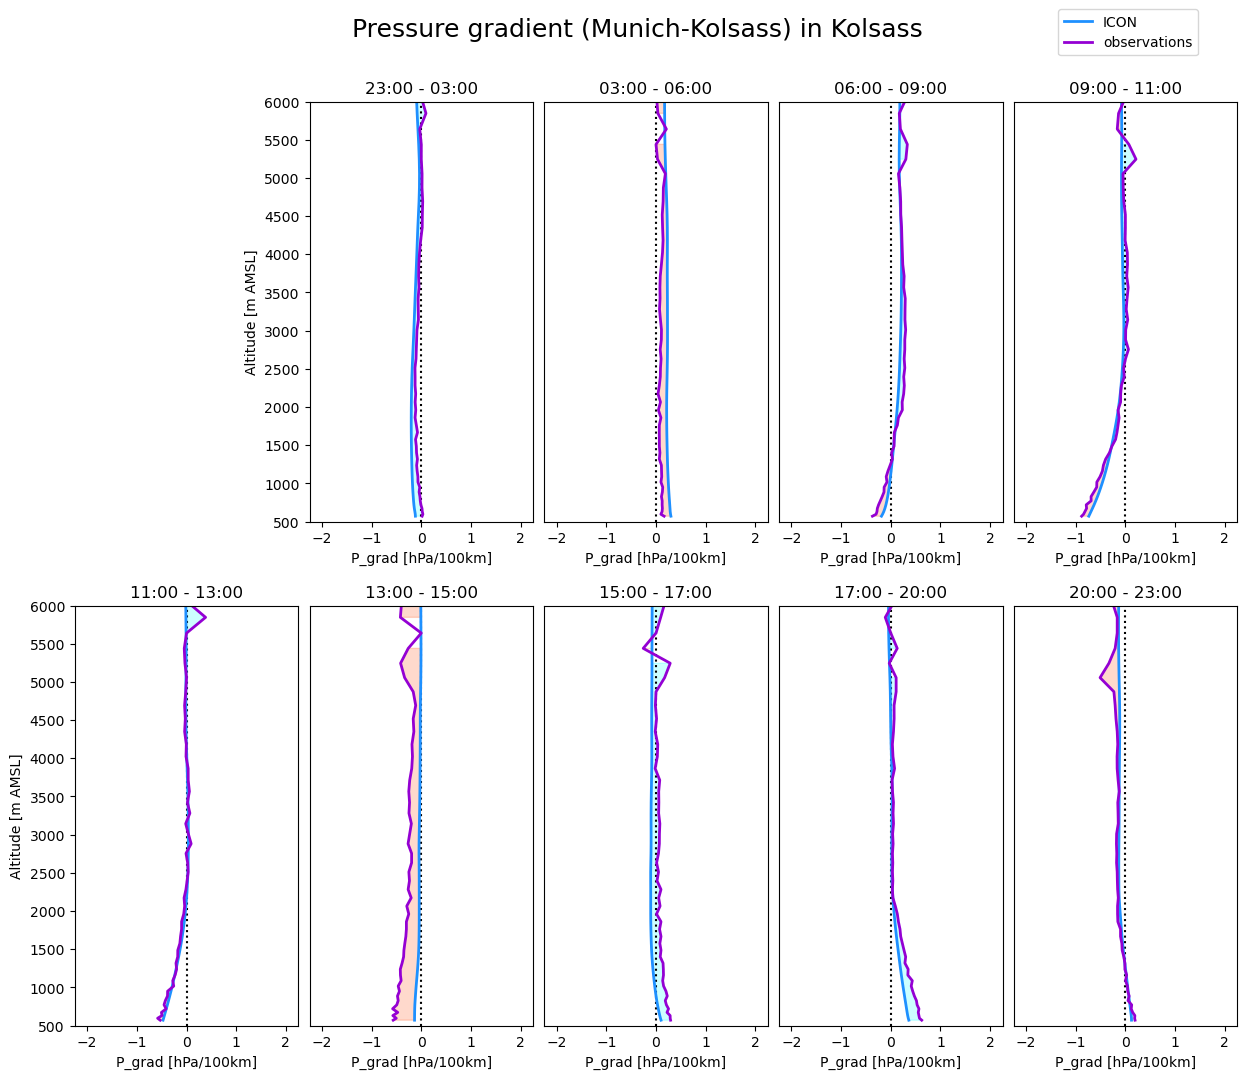

In [16]:
## PLOT ALL PROFILES DIFFERENCIES ##
# settings
cvar = vf.P
pvar = vf.P_grad
xmin=-2.25
xmax=2.25

ymin=500
ymax=6000

## COMPUTE THE TENDENCIES BETWEEN RS ##
# diffname = pvar.name+'_diff'
plotdates_model_list = list(plotdates_model)
htd_data_model['kols'][pvar.name] = np.empty((len(plotdates_model_list),73))
htd_data_kolsrs_interp[pvar.name] = np.empty((10,73))

for now in range(1,10):
    # dates
    pdate_now = plotdates_rs[now]
    pdate_before = plotdates_rs[now-1]
    delt=pdate_now-pdate_before
    # model
    sounding_model_now = np.array(htd_data_model['kols'][cvar.name][plotdates_model_list.index(pdate_now),:][0:73])
    sounding_model_before = np.array(htd_data_model['kols'][cvar.name][plotdates_model_list.index(pdate_before),:][0:73])
    htd_data_model['kols'][pvar.name][plotdates_model_list.index(pdate_now)] = (sounding_model_now-sounding_model_before)/(delt.seconds/3600)
     
    # rs
    sounding_rs_interp_now = np.array(htd_data_kolsrs_interp[cvar.name][now,:])
    sounding_rs_interp_before = np.array(htd_data_kolsrs_interp[cvar.name][now-1,:])
    htd_data_kolsrs_interp[pvar.name][now] = (sounding_rs_interp_now - sounding_rs_interp_before)/(delt.seconds/3600)

## PLOT ##
# plots
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2,wspace=0.05)
f.suptitle(pvar.title+' in '+loc.name , fontsize=18, y=0.95)
for index, ax in enumerate(axes.ravel()):
    pdate = plotdates_rs[index]
    plot_sounding(pvar, pdate,lf.kols, ax)
    # x
    xdelticks=5
    ax.set_xlim([xmin,xmax])
    ax.set_xlabel(pvar.name+' '+pvar.units)
    # ax.set_xticklabels(['',285,290,295,''])
    # y
    ydelticks=500
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel(None)
    ax.set_yticks([])
    ax.vlines(0,ymin,ymax,colors='k', linestyles='dotted')
    ax.set_title(plotdates_rs[index-1].strftime('%H:%M')+' - '+pdate.strftime('%H:%M'), fontsize=12)
# set y ticks to left plot
f.delaxes(axes[0,0])
axes[0,1].set_ylabel('Altitude [m AMSL]')
axes[0,1].set_yticks(np.arange(ymin,ymax+1,ydelticks))
axes[1,0].set_ylabel('Altitude [m AMSL]')
axes[1,0].set_yticks(np.arange(ymin,ymax+1,ydelticks))
plt.legend(loc=(0.2,2.31))
plt.show()